In [1]:
import h5py
import numpy as np
import pickle
import scipy
from scipy.stats import norm
from collections import defaultdict

import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
#textsize = 'xx-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 18,
         'axes.titlesize': 22,
         'xtick.labelsize': 16,
         'ytick.labelsize': 16,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt

import dynesty
import seaborn as sns
from dynesty import utils as dyfunc
from getdist import plots, MCSamples

%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../code')
import plotter
import utils
from utils import *

In [2]:
plot_dir = '../plots/plots_2022-03-21'

# Style, labels, and general

In [3]:
statistics = ['wp', 'xi', 'xi2', 'upf', 'mcf']
stat_strs_single = np.loadtxt('../tables/statistic_sets_single.txt', dtype=str)
stat_strs_addin = np.loadtxt('../tables/statistic_sets_addin.txt', dtype=str)
stat_strs_addin_full = np.concatenate((['wp'], stat_strs_addin))
stat_strs_scale = np.concatenate((stat_strs_single, ['wp_xi_xi2', 'wp_xi_xi2_mcf', 'wp_xi_xi2_upf_mcf']))

params_keydeliverable = ['Omega_m', 'sigma_8', 'f', 'fsigma8']
params_keycosmo = ['Omega_m', 'sigma_8', 'f']
params_keyhodab = ['M_sat', 'v_bs', 'f_env']
params_keymix = ['Omega_m', 'sigma_8', 'f', 'M_sat', 'v_bs', 'f_env']

id_pairs = np.loadtxt('../tables/id_pairs_recovery_test_70.txt', delimiter=',', dtype=np.int)

In [4]:
labels_single = [
                 make_label('wp'),
                 make_label('xi'),
                 make_label('xi2'),
                 make_label('upf'),
                 make_label('mcf')
                ]
labels_addin = [
                 make_label('wp'),
                 '+'+make_label('xi'),
                 '+'+make_label('xi2'),
                 '+'+make_label('upf'),
                 '+'+make_label('mcf'),
                ]
labels_addin_full = [
                 make_label('wp'),
                 make_label(['wp', 'xi']),
                 make_label(['wp', 'xi', 'xi2']),
                 make_label(['wp', 'xi', 'xi2', 'upf']),
                 make_label(['wp', 'xi', 'xi2', 'upf', 'mcf'])
                ]
labels_scale = np.concatenate((labels_single, 
                               [make_label(['wp', 'xi', 'xi2']),
                                make_label(['wp', 'xi', 'xi2', 'mcf']),
                                make_label(['wp', 'xi', 'xi2', 'upf', 'mcf'])]))

In [5]:
#colors_single = ['#73B9F3', '#25B98C', '#E0CA20', '#F79025', '#E65732', ]
#colors_single = ['#73B9F3', '#25B965', '#F1D819', '#F58804', '#FF2057', ]
#colors_single = ['#73B9F3', '#42ECD9', '#2BC35C', '#F59104', '#FF2057', ]
#colors_single = ['#73B9F3', '#336ADE', '#0CAB93', '#4CE266', '#D6B813', ]
colors_single = ['#73B9F3', '#2B66CE', '#31D8BF', '#FFB142', '#F97FF0']

colors_addin = ['#73B9F3', '#8973F5', '#952DAD', '#D81471', '#B70D0D']
colors_scale = np.concatenate((colors_single, 
                               [colors_addin[2], '#E64C03', colors_addin[-1]]))
colors_cov = ['#7B767B', colors_addin[-1]]

## Loading in data

Load in 70-model recovery test result dictionaries:

In [6]:
results_dict_dir = '../data_products/results_dicts'

In [7]:
chaintag_prior = 'prior'
prior_dict = utils.construct_results_dict(chaintag_prior)

In [8]:
fn_results_dict_single = f'{results_dict_dir}/results_dict_single.npy'
results_dict_single = np.load(fn_results_dict_single, allow_pickle=True).item()

In [9]:
fn_results_dict_addin_full = f'{results_dict_dir}/results_dict_addin_full.npy'
results_dict_addin_full = np.load(fn_results_dict_addin_full, allow_pickle=True).item()

In [10]:
fn_results_dict_wpmaxscale6 = f'{results_dict_dir}/results_dict_wpmaxscale6.npy'
results_dict_wpmaxscale6 = np.load(fn_results_dict_wpmaxscale6, allow_pickle=True).item()

In [11]:
fn_results_dict_minscales = f'{results_dict_dir}/results_dict_minscales.npy'
results_dict_minscales = np.load(fn_results_dict_minscales, allow_pickle=True).item()

In [12]:
fn_results_dict_maxscales = f'{results_dict_dir}/results_dict_maxscales.npy'
results_dict_maxscales = np.load(fn_results_dict_maxscales, allow_pickle=True).item()

In [13]:
fn_results_dict_minscales_more = f'{results_dict_dir}/results_dict_minscales_more.npy'
results_dict_minscales_more = np.load(fn_results_dict_minscales_more, allow_pickle=True).item()

In [14]:
fn_results_dict_maxscales_more = f'{results_dict_dir}/results_dict_maxscales_more.npy'
results_dict_maxscales_more = np.load(fn_results_dict_maxscales_more, allow_pickle=True).item()

In [15]:
fn_results_dict_minscales_upfmatch = f'{results_dict_dir}/results_dict_minscales_upfmatch.npy'
results_dict_minscales_upfmatch = np.load(fn_results_dict_minscales_upfmatch, allow_pickle=True).item()

In [16]:
fn_results_dict_maxscales_upfmatch = f'{results_dict_dir}/results_dict_maxscales_upfmatch.npy'
results_dict_maxscales_upfmatch = np.load(fn_results_dict_maxscales_upfmatch, allow_pickle=True).item()

## Scales with more combos, no UPF

In [17]:
stat_strs_scale_more = np.concatenate((stat_strs_single, 
                                       ['xi_xi2', 'wp_xi_xi2', 'wp_xi_xi2_mcf', 'wp_xi_xi2_upf_mcf']))


labels_scale_more = np.concatenate((labels_single, 
                               [make_label(['xi', 'xi2']),
                                make_label(['wp', 'xi', 'xi2']),
                                make_label(['wp', 'xi', 'xi2', 'mcf']),
                                make_label(['wp', 'xi', 'xi2', 'upf', 'mcf'])]))

# old orange: '#E64C03'
colors_scale_more = np.concatenate((colors_single, 
                               ['navy', colors_addin[2], '#ff33b4', colors_addin[-1]]))

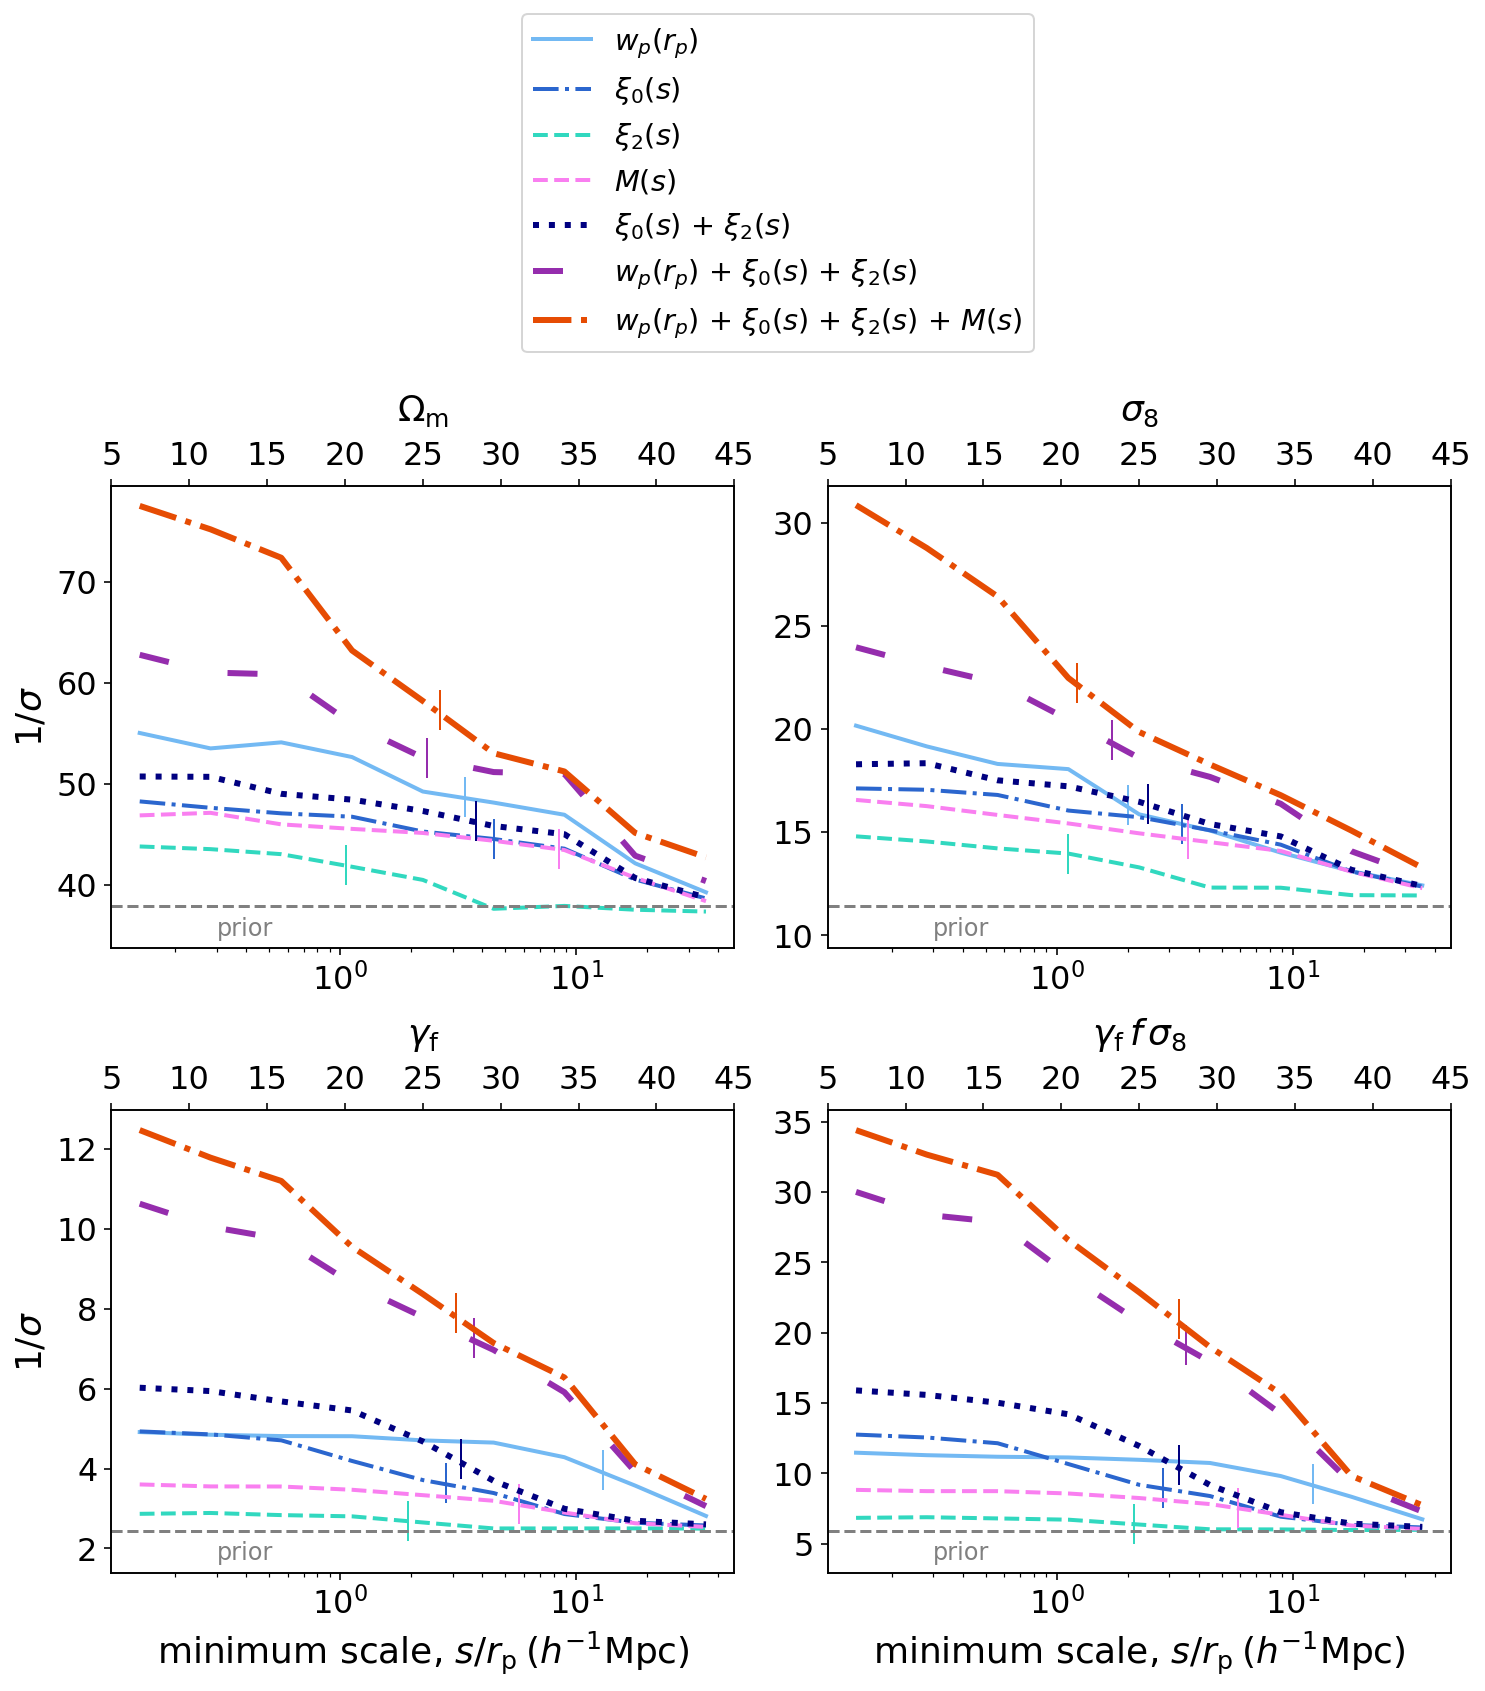

In [27]:
idxs = [0, 1, 2, 4, 5, 6, 7]
lws = np.array([2,2,2,2,2,3,3,3,3])
long_dash = (0, (5, 10))
lss = np.array(['-', '-.', '--', ':', '--', ':', long_dash, '-.', '-'])
min_scales = np.arange(0,9)
plotter.plot_scale_dependence_figure(min_scales, results_dict_minscales_more, prior_dict, 
                             params_keydeliverable, stat_strs_scale_more[idxs], id_pairs, 
                             labels_scale_more[idxs], colors_scale_more[idxs],
                             lss=lss[idxs], lws=lws[idxs], 
                             xlabel=r'minimum scale, $s/r_\mathrm{p} \: (h^{-1}\mathrm{Mpc})$',
                             comparison_dicts=results_dict_maxscales_more)
#plt.savefig(f'{plot_dir}/scale_dependence.pdf', bbox_inches='tight')

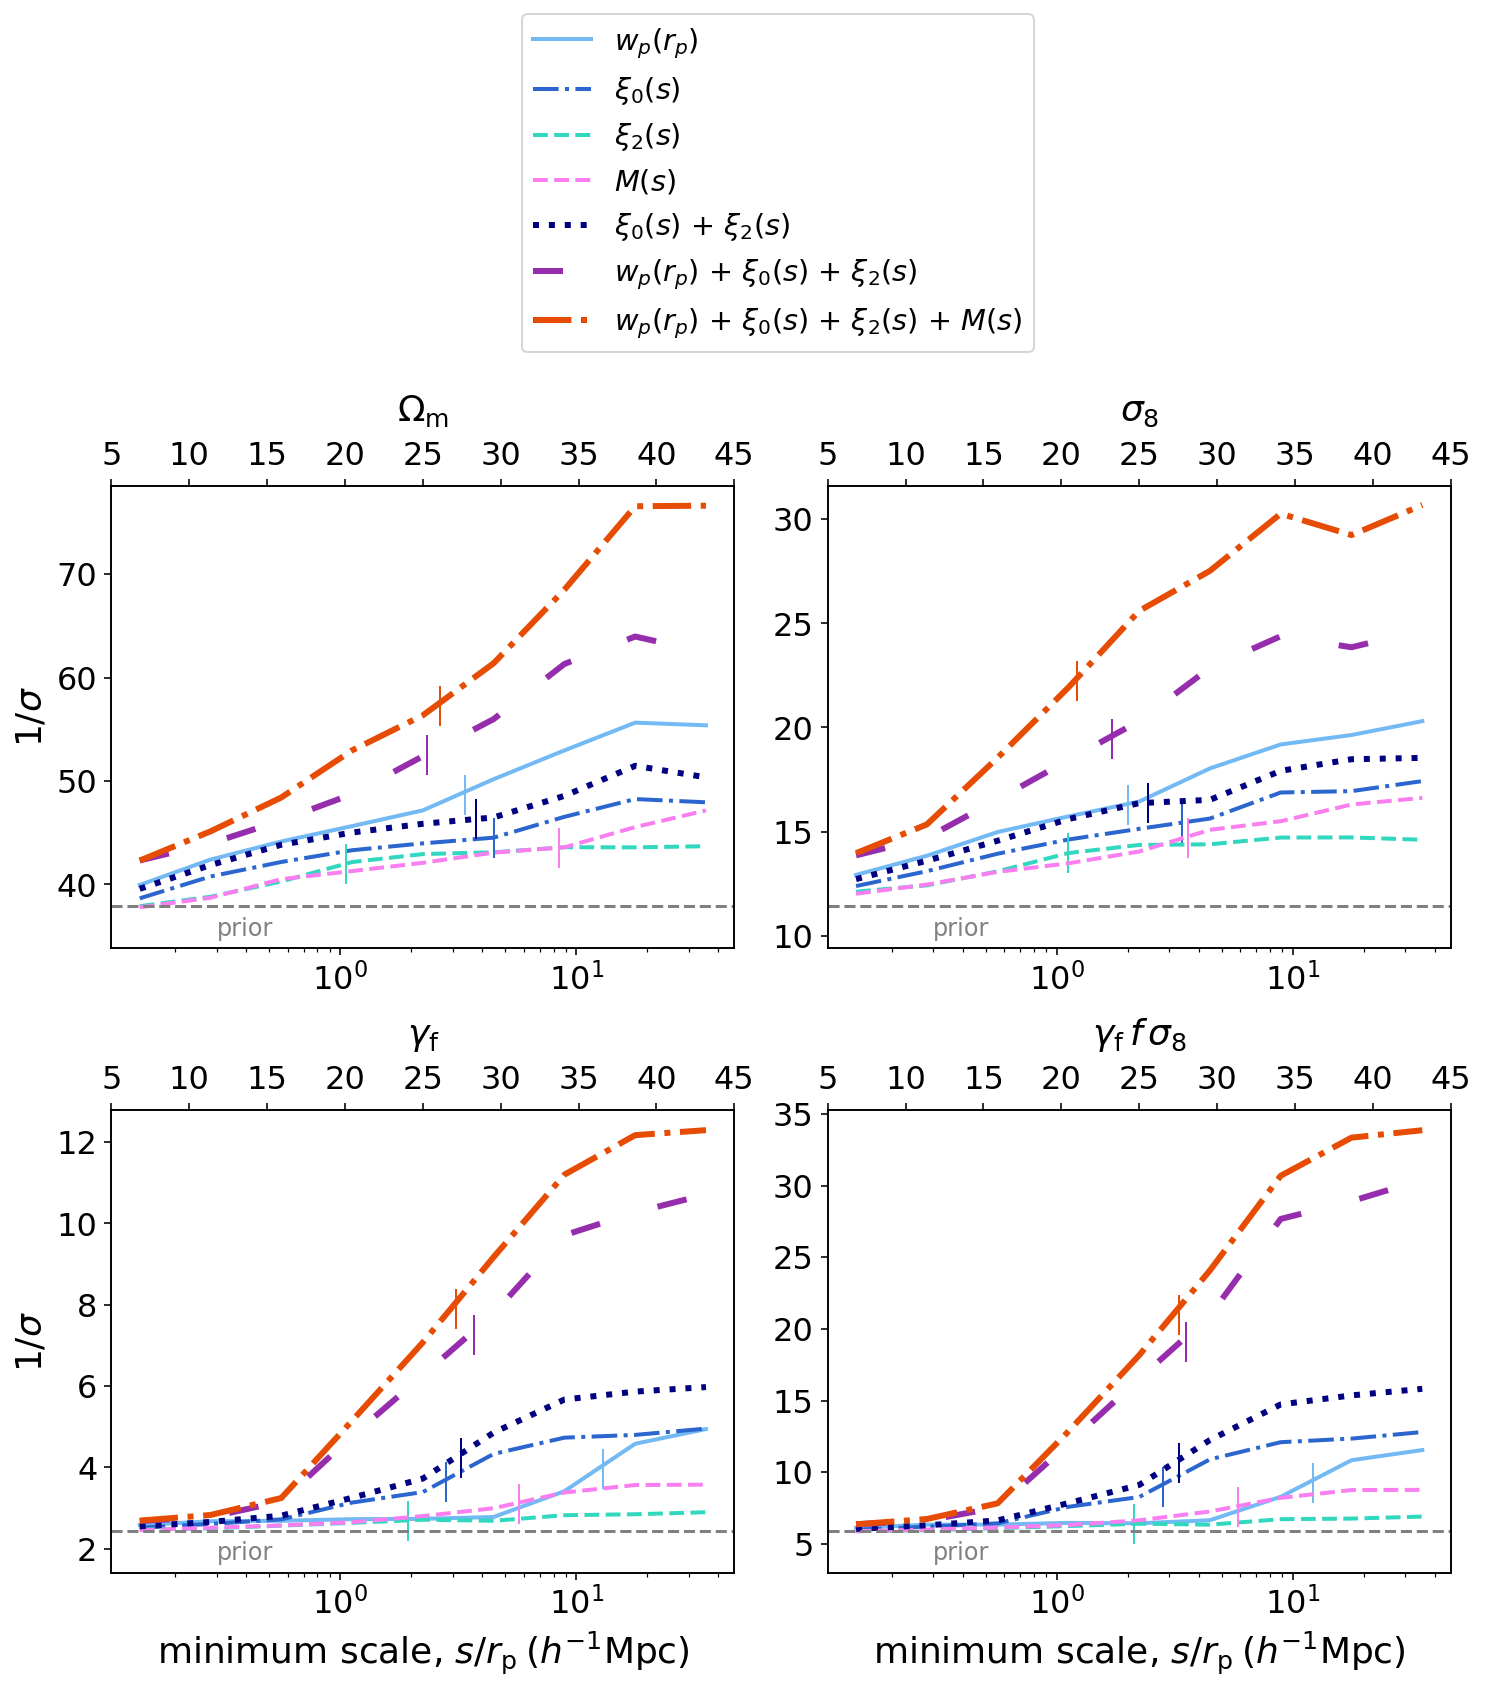

In [28]:
idxs = [0, 1, 2, 4, 5, 6, 7]
lws = np.array([2,2,2,2,2,3,3,3,3])
long_dash = (0, (5, 10))
lss = np.array(['-', '-.', '--', ':', '--', ':', long_dash, '-.', '-'])
max_scales = np.arange(0,9)
plotter.plot_scale_dependence_figure(max_scales, results_dict_maxscales_more, prior_dict, 
                             params_keydeliverable, stat_strs_scale_more[idxs], id_pairs, 
                             labels_scale_more[idxs], colors_scale_more[idxs],
                             lss=lss[idxs], lws=lws[idxs], 
                             xlabel=r'minimum scale, $s/r_\mathrm{p} \: (h^{-1}\mathrm{Mpc})$',
                             comparison_dicts=results_dict_minscales_more)
#plt.savefig(f'{plot_dir}/scale_dependence.pdf', bbox_inches='tight')

## Scales with UPF matched

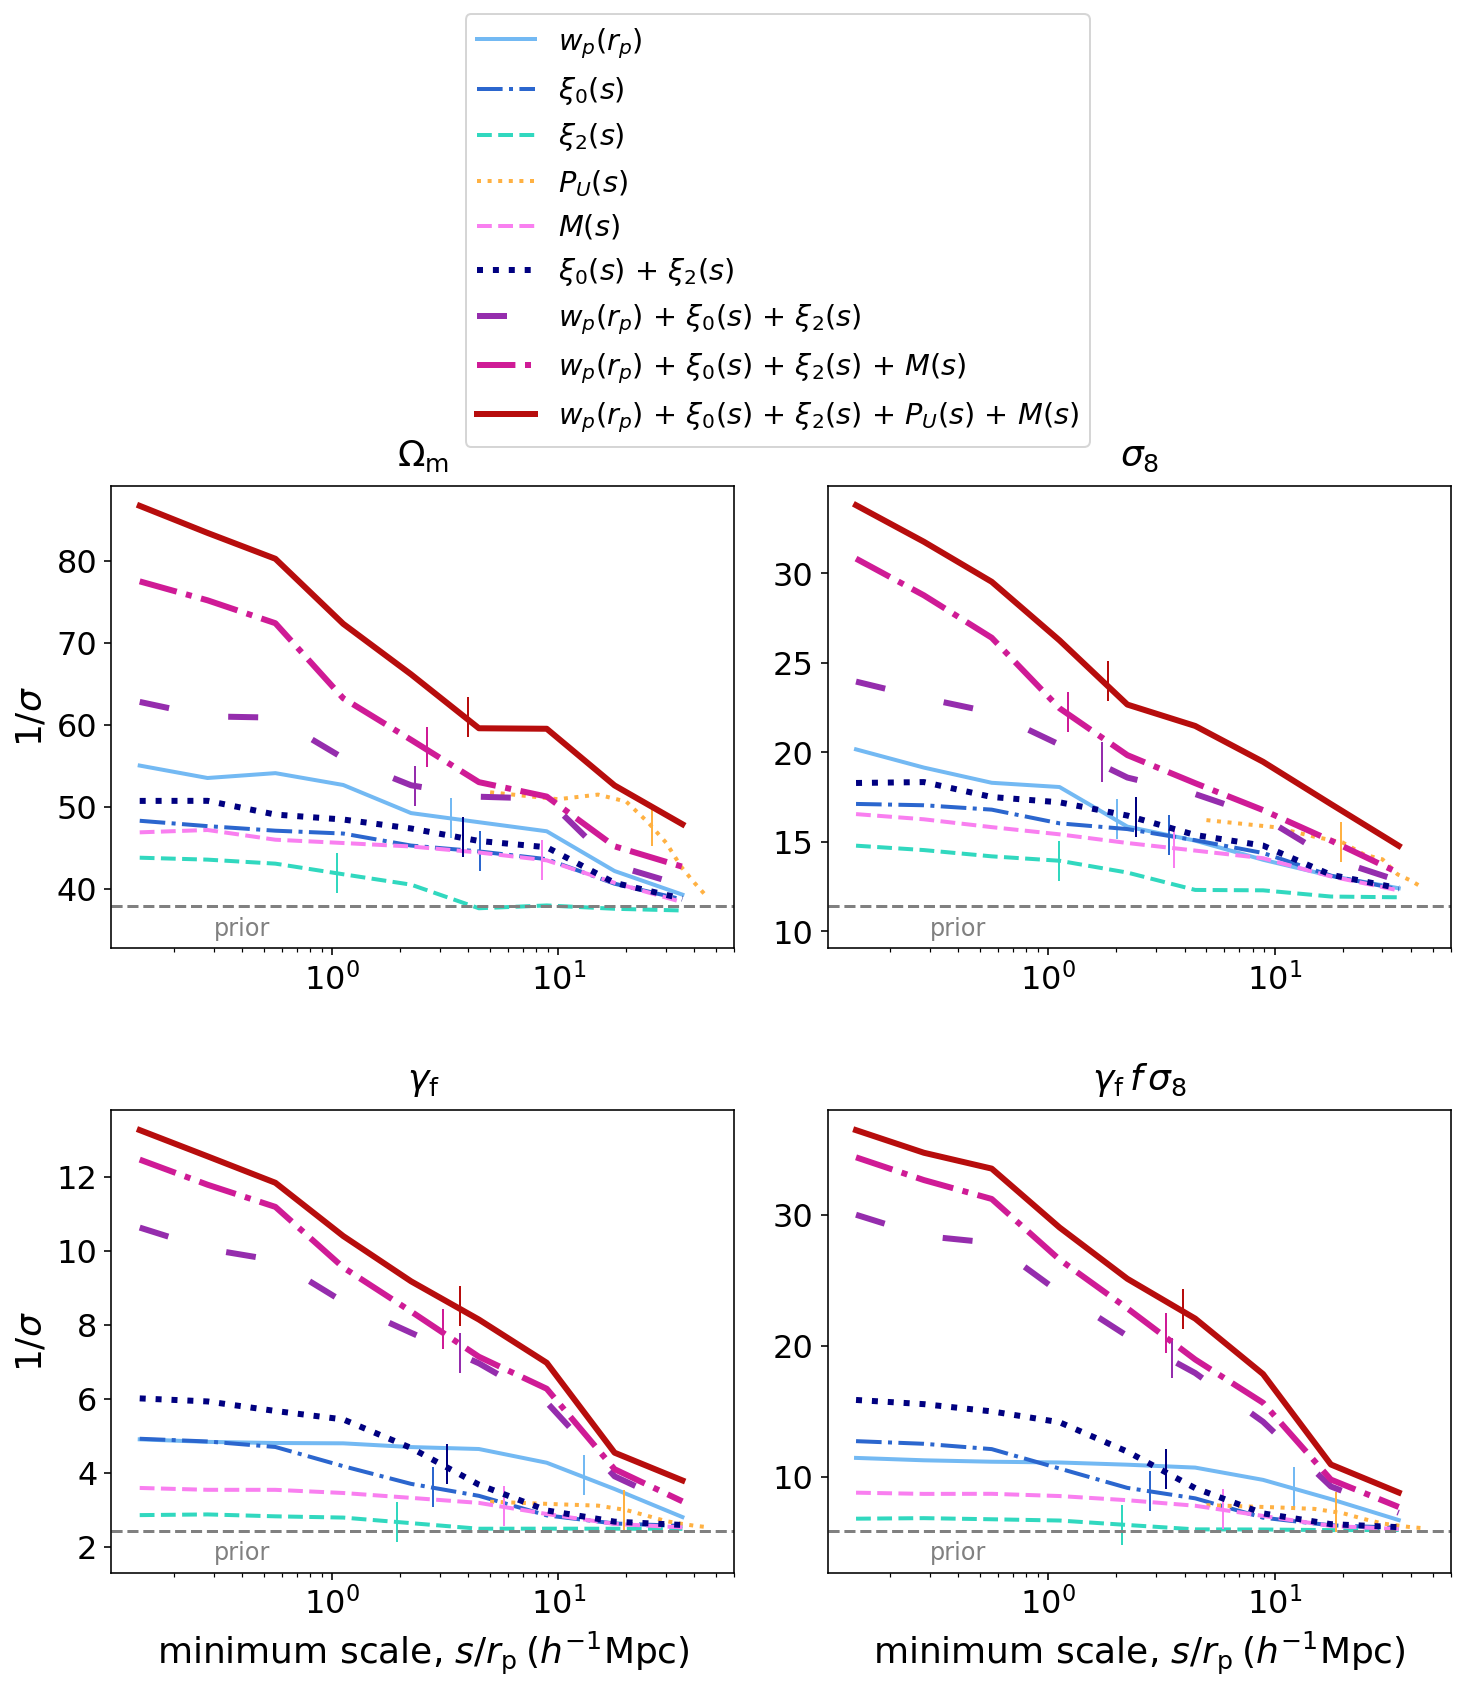

In [20]:
idxs = np.arange(9)
lws = np.array([2,2,2,2,2,3,3,3,3])
long_dash = (0, (5, 10))
lss = np.array(['-', '-.', '--', ':', '--', ':', long_dash, '-.', '-'])
min_scales = np.arange(0,9)
plotter.plot_scale_dependence_figure(min_scales, results_dict_minscales_upfmatch, prior_dict, 
                             params_keydeliverable, stat_strs_scale_more[idxs], id_pairs, 
                             labels_scale_more[idxs], colors_scale_more[idxs],
                             lss=lss[idxs], lws=lws[idxs], 
                             xlabel=r'minimum scale, $s/r_\mathrm{p} \: (h^{-1}\mathrm{Mpc})$',
                             comparison_dicts=results_dict_maxscales_upfmatch, show_top_axis=False)
#plt.savefig(f'{plot_dir}/scale_dependence.pdf', bbox_inches='tight')

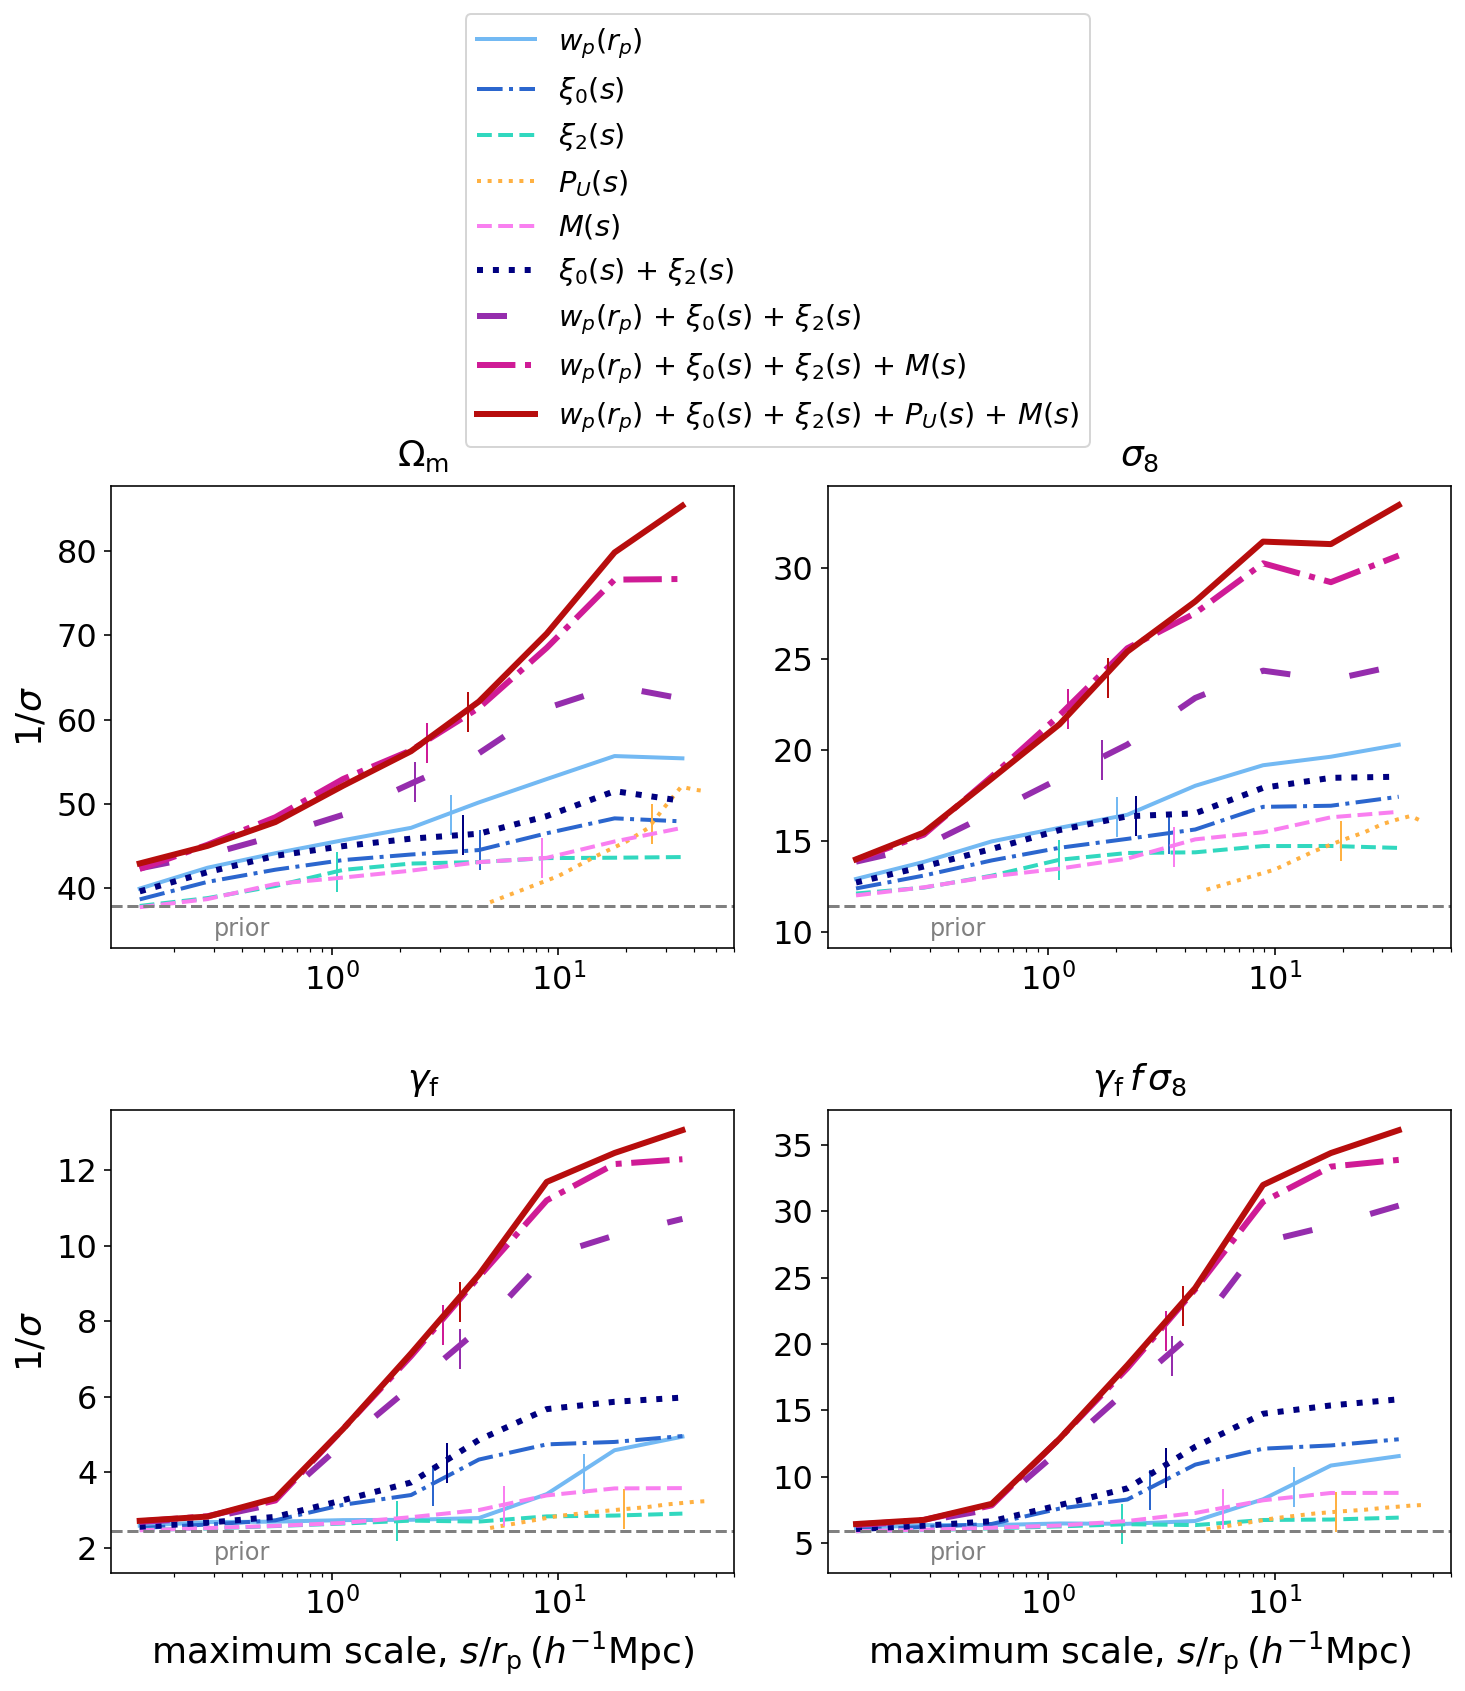

In [23]:
idxs = np.arange(9)
lws = np.array([2,2,2,2,2,3,3,3,3])
long_dash = (0, (5, 10))
lss = np.array(['-', '-.', '--', ':', '--', ':', long_dash, '-.', '-'])
max_scales = np.arange(0,9)
plotter.plot_scale_dependence_figure(max_scales, results_dict_maxscales_upfmatch, prior_dict, 
                             params_keydeliverable, stat_strs_scale_more[idxs], id_pairs, 
                             labels_scale_more[idxs], colors_scale_more[idxs],
                             lss=lss[idxs], lws=lws[idxs], 
                             xlabel=r'maximum scale, $s/r_\mathrm{p} \: (h^{-1}\mathrm{Mpc})$',
                             comparison_dicts=results_dict_minscales_upfmatch, show_top_axis=False)
#plt.savefig(f'{plot_dir}/scale_dependence.pdf', bbox_inches='tight')

## Figures for talk

### Cosmology contours

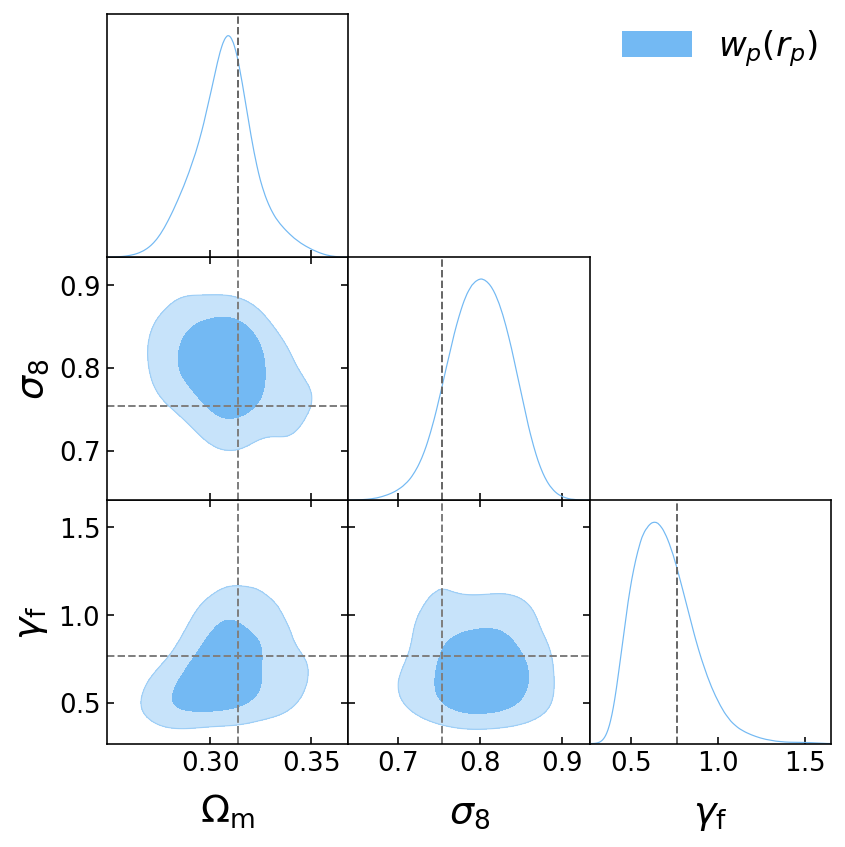

In [39]:
chaintags = [
             'wp_c1h12_all',
            ]
g = plotter.plot_contours(chaintags, colors=colors_addin[:1],
                          legend_labels=labels_addin[:1], legend_loc='upper right',
                          params_toplot=['Omega_m', 'sigma_8', 'f'])
plt.savefig(f'{plot_dir}/contours_cosmo_wp.png', bbox_inches='tight')

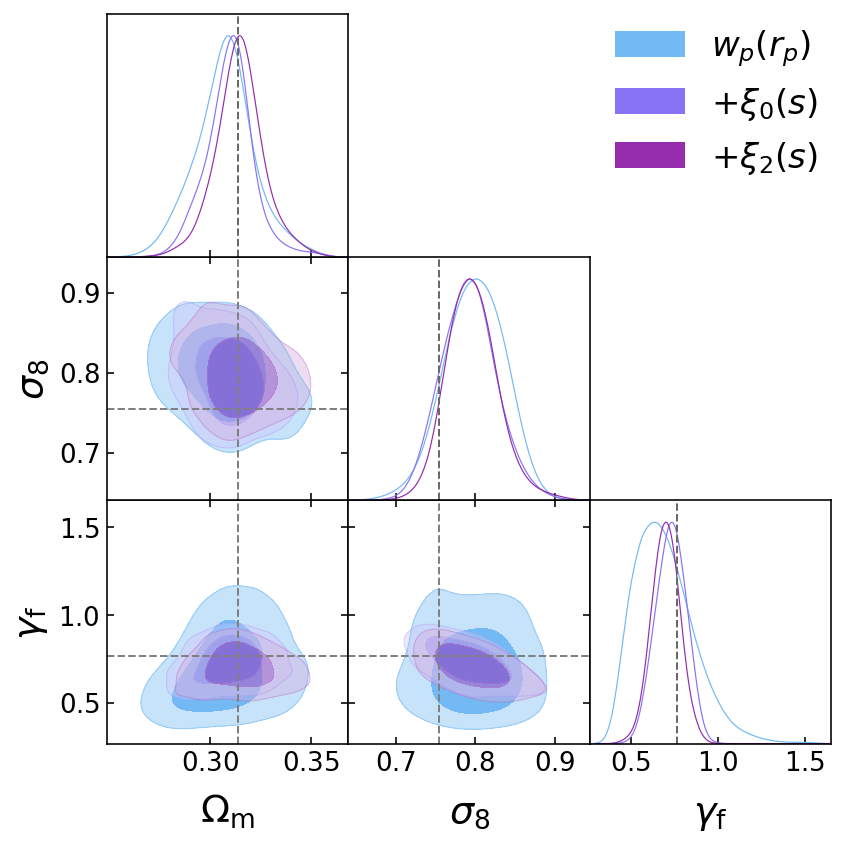

In [40]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
            ]
g = plotter.plot_contours(chaintags, colors=colors_addin[:3],
                          legend_labels=labels_addin[:3], legend_loc='upper right',
                          params_toplot=['Omega_m', 'sigma_8', 'f'])
plt.savefig(f'{plot_dir}/contours_cosmo_wp_xi_xi2.png', bbox_inches='tight')

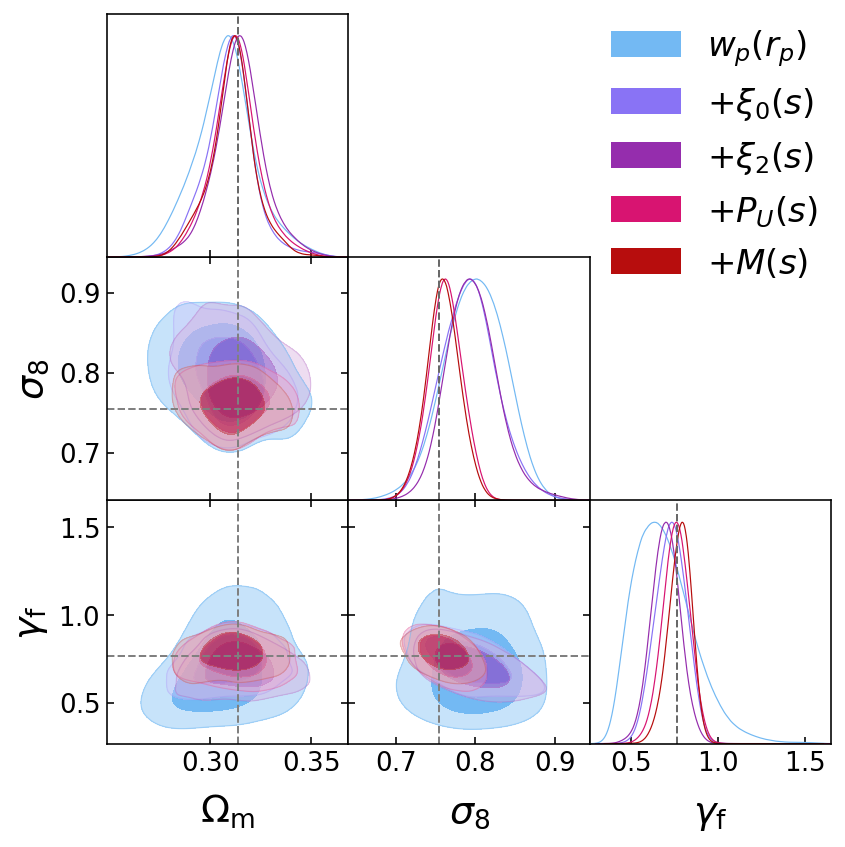

In [41]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
             'wp_xi_xi2_upf_c1h12_all',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
g = plotter.plot_contours(chaintags, colors=colors_addin,
                          legend_labels=labels_addin, legend_loc='upper right',
                          params_toplot=['Omega_m', 'sigma_8', 'f'])
plt.savefig(f'{plot_dir}/contours_cosmo_wp_xi_xi2_upf_mcf.png', bbox_inches='tight')

### HOD / AB contours

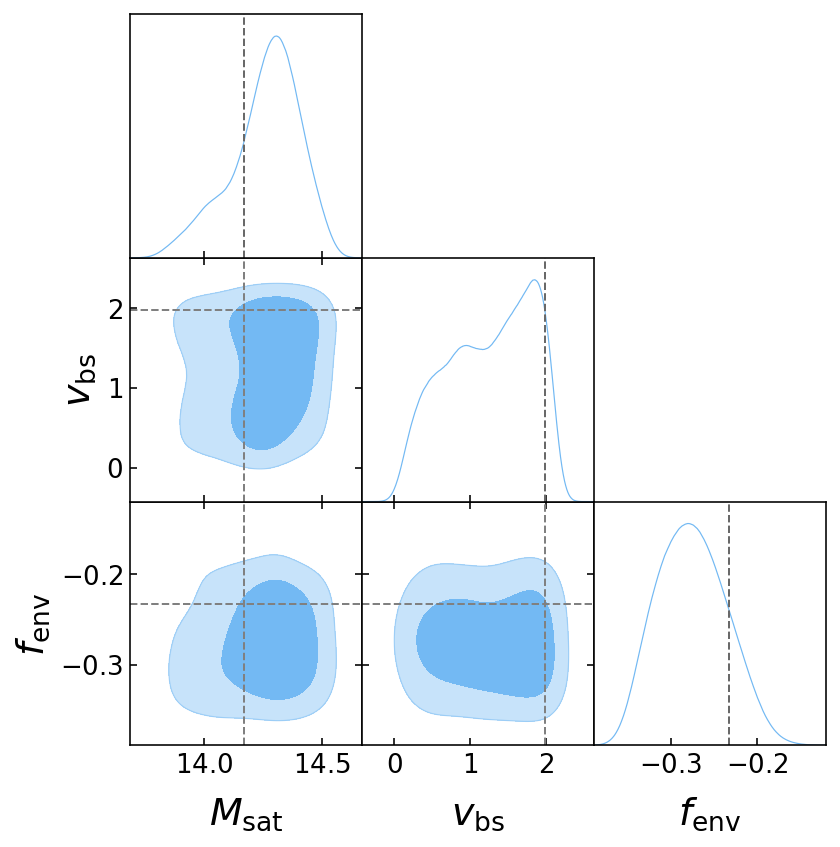

In [42]:
chaintags = [
             'wp_c1h12_all',
            ]
g = plotter.plot_contours(chaintags, colors=colors_addin[:1],
                          params_toplot=['M_sat', 'v_bs', 'f_env'])
plt.savefig(f'{plot_dir}/contours_hod_wp.png', bbox_inches='tight')

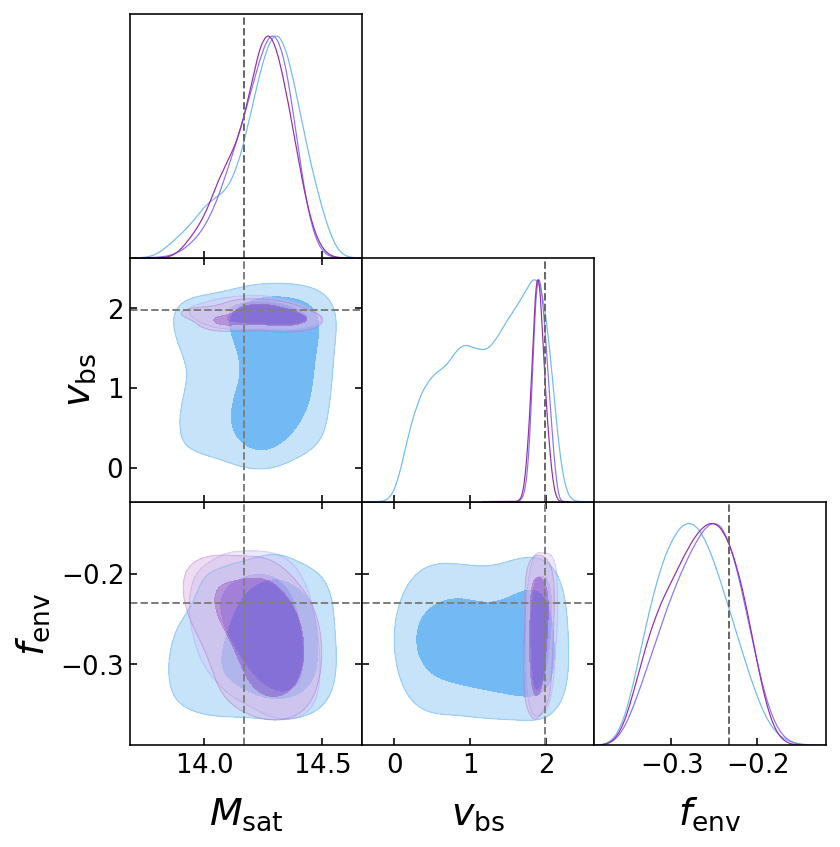

In [43]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
            ]
g = plotter.plot_contours(chaintags, colors=colors_addin[:3],
                          params_toplot=['M_sat', 'v_bs', 'f_env'])
plt.savefig(f'{plot_dir}/contours_hod_wp_xi_xi2.png', bbox_inches='tight')

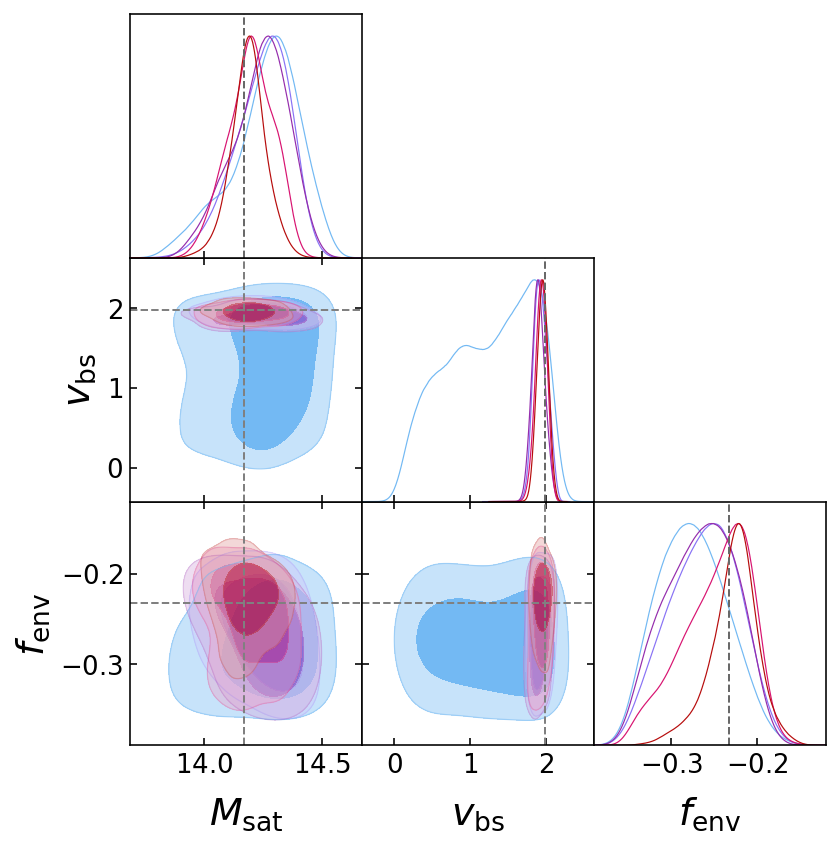

In [44]:
chaintags = [
             'wp_c1h12_all',
             'wp_xi_c1h12_all',
             'wp_xi_xi2_c1h12_all',
             'wp_xi_xi2_upf_c1h12_all',
             'wp_xi_xi2_upf_mcf_c1h12_all',
            ]
g = plotter.plot_contours(chaintags, colors=colors_addin,
                          params_toplot=['M_sat', 'v_bs', 'f_env'])
plt.savefig(f'{plot_dir}/contours_hod_wp_xi_xi2_upf_mcf.png', bbox_inches='tight')